In [10]:
library(tensorflow)
library(tfdatasets)
library(dplyr)
library(glue)
library(data.table)
library(ggplot2)
library(keras)
library(tfprobability)
library(stringr)
source('utils.R')

print(tf$version$VERSION)
print(tfp_version() ) ## version checks

[1] "2.1.0"
[1] ‘0.9’


In [11]:
## load data Channel Dataset-----------------------------------------------------
load(file = 'df_paths.rdata',verbose = T)

encoded_size <- 2L  ## number of dims ? Bivariate
ev_shape <-  1L
batch_size = 32

latent_dim <- 2L
n_gru = 7
ds = train_paths[ str_detect(str_c(V1,V2,V3,V4,V5),'1.*(5|7)')==target]
print(table(ds$target))

ft_spec <- ds %>%
  select(-customer_id,-path_no,-path,) %>%
  feature_spec(target ~ .) %>%
  step_categorical_column_with_vocabulary_list(starts_with("V"),vocabulary_list = list('channel_0', 'channel_1', 'channel_2', 'channel_3', 'channel_4', 'channel_5', 'channel_6', 'channel_7', 'channel_8')) %>%
  step_embedding_column(starts_with("V"), dimension = function(vocab_size) as.integer(sqrt(vocab_size) + 1)   ## dim=4
  ) %>%
  fit()

ft_spec$dense_features() 

Loading objects:
  df_paths
  train_paths
  test_paths

    0     1 
12124  5479 


$embedding_V1
EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='V1', vocabulary_list=('channel_0', 'channel_1', 'channel_2', 'channel_3', 'channel_4', 'channel_5', 'channel_6', 'channel_7', 'channel_8'), dtype=tf.string, default_value=-1, num_oov_buckets=0), dimension=4, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True)

$embedding_V2
EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='V2', vocabulary_list=('channel_0', 'channel_1', 'channel_2', 'channel_3', 'channel_4', 'channel_5', 'channel_6', 'channel_7', 'channel_8'), dtype=tf.string, default_value=-1, num_oov_buckets=0), dimension=4, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True)

$embedding_V3
EmbeddingColumn(categorical_column=VocabularyListCategoricalColumn(key='V3',

In [12]:
## The Models
encoder_model_ts <- function(name = NULL,ngru=n_gru) {
  keras_model_custom(name = name, function(self) {
    self$dense_features <- layer_dense_features(feature_columns=ft_spec$dense_features()) ## ft_spec
    self$reshape = layer_reshape(target_shape= list(5,4)) 
    self$gru1  =   (layer=layer_gru(units = ngru, dropout=0.2 ,recurrent_dropout = 0.1,return_sequences =TRUE) )
    self$gru2  =   (layer=layer_gru(units = ngru, dropout=0.2 ,recurrent_dropout = 0.1,return_sequences =FALSE) )
    self$dense <- layer_dense(units = 2 * latent_dim)
    function (inputs, mask = NULL) {
      x <- inputs[[1]]  ## x, the input, is of size (batch_size, max_length_input) or timesteps Tx
      dense_out = x %>%  
        self$dense_features()  %>% # shape=(batch, col*embed)
        self$reshape() %>% 
        self$gru1(initial_state = inputs[[2]] ) %>%  
        self$gru2(initial_state = inputs[[2]] ) %>%   ## shape: 100/5/5 and 100/5
        self$dense() 
         tfd_multivariate_normal_diag(loc = dense_out[, 1:encoded_size],
                                      scale_diag = tf$nn$softplus(dense_out[, (encoded_size + 1):(2 * encoded_size)] + 1e-5))  
    }
  })
}

decoder_model_ts <- function(name = NULL) {
  keras_model_custom(name = name, function(self) {
    self$dense1 <- layer_dense(units = 7 * 7 , activation = "relu") ## 
    self$dense2 <- layer_dense(units = 1,activation = "sigmoid")  ## 
    function (x, mask = NULL) {
    x =  x %>%
        self$dense1() %>%
        self$dense2() 
      # tfd_independent(tfd_bernoulli(logits = x),reinterpreted_batch_ndims = 1L)
    x
    }
  })
}
compute_kl_loss <- function(latent_prior, approx_posterior, approx_posterior_sample) {
  kl_div <- approx_posterior$log_prob(approx_posterior_sample) -  latent_prior$log_prob(approx_posterior_sample)
  avg_kl_div <- tf$reduce_mean(kl_div)
  abs(avg_kl_div)
}

# Learnable Prior -------------------------------------------------------------------
mixture_components <- 4L
learnable_prior_model <-  function(name = NULL, latent_dim, mixture_components) {
  keras_model_custom(name = name, function(self) {
    self$loc <-   tf$Variable( initial_value=tf$zeros(shape = c(mixture_components, latent_dim)),  name = "loc",   shape = list(mixture_components, latent_dim),   dtype = tf$float32 )
    self$raw_scale_diag <- tf$Variable( initial_value= tf$zeros(shape = c(mixture_components, latent_dim)),  name = "raw_scale_diag",     shape = c(mixture_components, latent_dim), dtype = tf$float32 )
    self$mixture_logits <-  tf$Variable( initial_value=tf$zeros(shape = c(mixture_components)), name = "mixture_logits",    shape = c(mixture_components),  dtype = tf$float32 )
    
    function (x, mask = NULL) {
      tfd_mixture_same_family(
        components_distribution = tfd_multivariate_normal_diag( loc = self$loc,   scale_diag = tf$nn$softplus(self$raw_scale_diag) ),
        mixture_distribution = tfd_categorical(logits = self$mixture_logits)
      )
      # Note how self$loc, self$raw_scale_diag and self$mixture_logits are TensorFlow Variables and thus, persistent and updatable by backprop.
    }
  })
}



In [13]:
## Training Loop -----------------------------------------------------------
print('training loop..')
optimizer <- tf$optimizers$Adam()
decoder_ts <- decoder_model_ts()
encoder_ts <- encoder_model_ts()
latent_prior_model <- learnable_prior_model(latent_dim = latent_dim, mixture_components = mixture_components)

encoder_init_hidden <- k_zeros(c(batch_size, n_gru), dtype='float32') 

ch_dataset = tensor_slices_dataset(ds) %>%   dataset_batch(batch_size = batch_size,drop_remainder=T) 
num_epochs <- 10
wt_crossentropy_loss = 3
wt_kl_loss = 1
batches_num <-  nrow(ds) / batch_size
num_samples = 10000

for (epoch in seq_len(num_epochs)) {
  iter <-   make_iterator_one_shot(ch_dataset)
  total_loss_kl <- total_loss_nll <- total_loss <- 0
  
  until_out_of_range({
    x <-  iterator_get_next(iter)
    with(tf$GradientTape(persistent = TRUE) %as% tape, {
      approx_posterior = encoder_ts( list(x,encoder_init_hidden))
      approx_posterior_sample <-   approx_posterior %>% tfd_sample(num_samples)  %>% k_mean(axis = 1)
      preds <- decoder_ts(approx_posterior_sample) 
      nll <-   wt_crossentropy_loss*tf$nn$sigmoid_cross_entropy_with_logits(logits = preds, labels = tf$reshape(x$target,shape = preds$shape) )
      latent_prior <- latent_prior_model(NULL) 
      kl_loss <-  wt_kl_loss* compute_kl_loss(  latent_prior,  approx_posterior,  approx_posterior_sample ) 
      loss <- (kl_loss + nll)
    }) ## batch over
    encoder_gradients <- tape$gradient(loss, encoder_ts$variables)
    decoder_gradients <- tape$gradient(loss, decoder_ts$variables)
    
    optimizer$apply_gradients(  purrr::transpose(list(encoder_gradients, encoder_ts$variables))   )
    optimizer$apply_gradients(  purrr::transpose(list(decoder_gradients, decoder_ts$variables))   )
    total_loss <- total_loss + loss
    total_loss_nll <- total_loss_nll + nll
    total_loss_kl <- total_loss_kl + kl_loss
  })
  print(
    glue(
      "Losses (epoch): {epoch}:",
      "  {mean((as.numeric(total_loss_nll))) %>% round(2)} nll",
      "  {(as.numeric(total_loss_kl)) %>% round(2)} kl",
      "  {mean((as.numeric(total_loss))) %>% round(2)} total"
    )
  )
  if (epoch %% 5 == 0) show_space(epoch,size = 15000,dataset=ch_dataset,encoder = encoder_ts,pre = '_lp')
}  ## train loop 


[1] "training loop.."
Losses (epoch): 1:  1155.65 nll  8.37 kl  1164.02 total
Losses (epoch): 2:  1035.47 nll  11.03 kl  1046.49 total
Losses (epoch): 3:  976.3 nll  8.28 kl  984.58 total
Losses (epoch): 4:  950.31 nll  5.83 kl  956.14 total
Losses (epoch): 5:  949.5 nll  4.07 kl  953.57 total


Saving 7 x 7 in image



Losses (epoch): 6:  949.22 nll  3.11 kl  952.32 total
Losses (epoch): 7:  949.05 nll  2.55 kl  951.6 total
Losses (epoch): 8:  948.92 nll  1.99 kl  950.91 total
Losses (epoch): 9:  948.84 nll  1.71 kl  950.55 total
Losses (epoch): 10:  948.78 nll  1.45 kl  950.23 total


Saving 7 x 7 in image



ERROR: Error in py_call_impl(callable, dots$args, dots$keywords): ValueError: Model <kerastools.model.RModel object at 0x15a27b9e8> cannot be saved because the input shapes have not been set. Usually, input shapes are automatically determined from calling .fit() or .predict(). To manually set the shapes, call model._set_inputs(inputs).

Detailed traceback: 
  File "/Users/vishhawa/Library/r-miniconda/envs/r-reticulate/lib/python3.6/site-packages/tensorflow_core/python/keras/saving/save.py", line 115, in save_model
    signatures, options)
  File "/Users/vishhawa/Library/r-miniconda/envs/r-reticulate/lib/python3.6/site-packages/tensorflow_core/python/keras/saving/saved_model/save.py", line 65, in save
    saving_utils.raise_model_input_error(model)
  File "/Users/vishhawa/Library/r-miniconda/envs/r-reticulate/lib/python3.6/site-packages/tensorflow_core/python/keras/saving/saving_utils.py", line 113, in raise_model_input_error
    'model._set_inputs(inputs).'.format(model))



Saving 7 x 7 in image



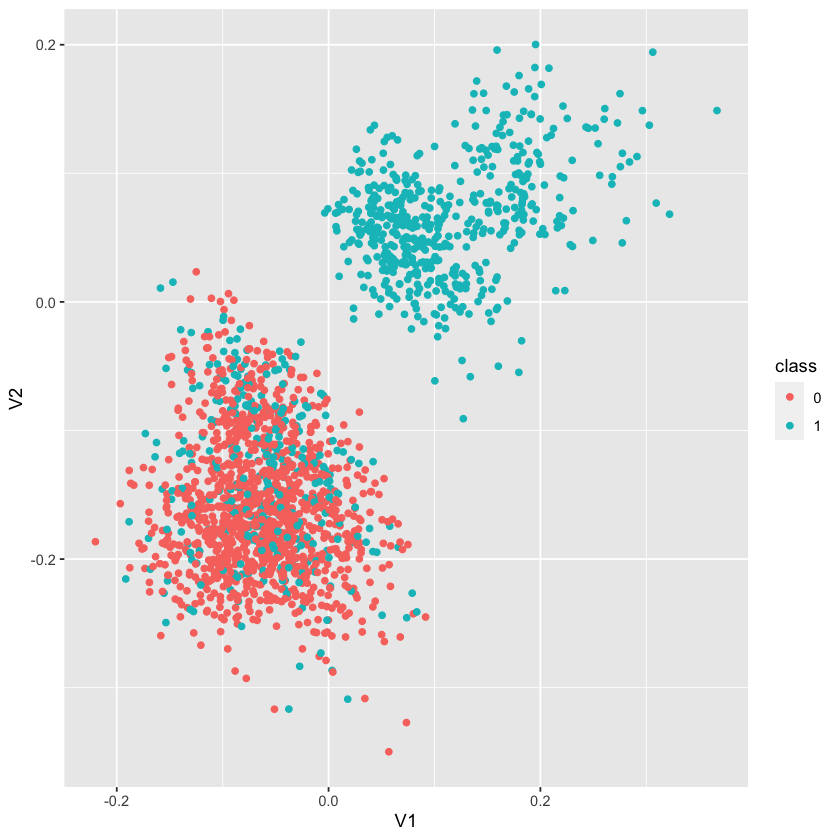

In [37]:
## test space -----------------------------------------------------

p_lp = show_space('test',size = 2000,encoder = encoder_ts, pre = '_lp',
                  dataset=tensor_slices_dataset(test_paths) %>%
                  dataset_batch(batch_size = batch_size,drop_remainder=T) )
p_lp

### Analyze Latent Space

Plot spatial density to observe areas of positive and negative regions. Plotting done with *ggplot()* 
Check out the regions, (contours profiles) and density as heat-map.

Saving 7 x 7 in image



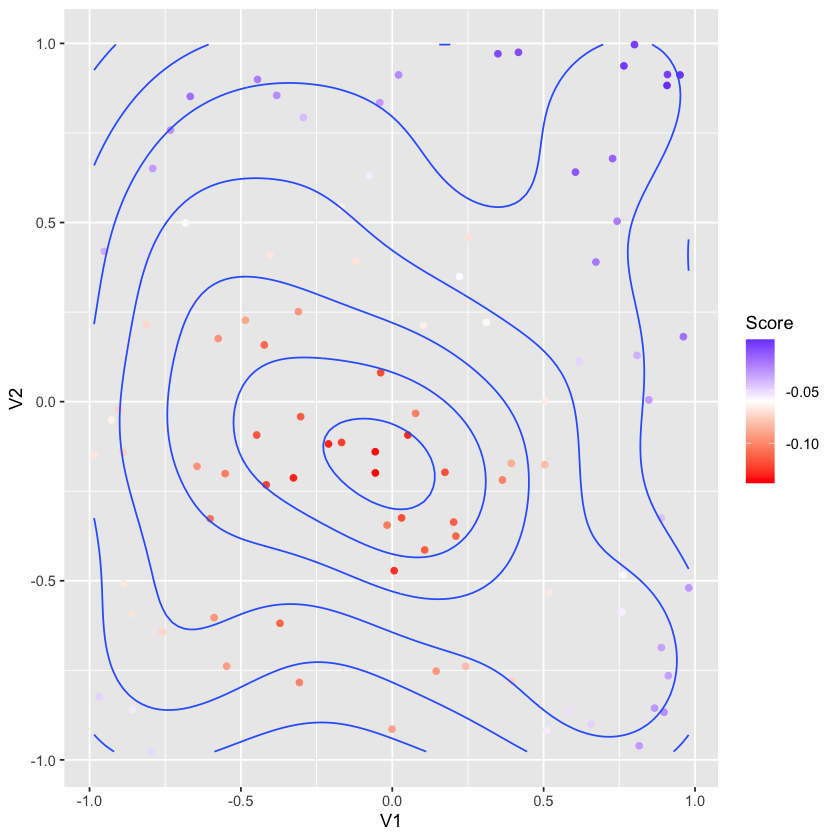

In [15]:
## Plot spatial density
size = 100
dat_points <- array(sample(c(1,-1),size,replace = T)*runif(size * 2,min = -1,max = 1), dim = c(size, 2))
spatial_density = compute_space(dat_points = dat_points)

ggplot(as.data.frame(spatial_density), aes(x = V1, y = V2, colour = Score))  +   geom_point(position = 'jitter') + scale_color_gradient2( midpoint = -0.06,low = 'red',  high = ("blue")) +
  geom_density2d()  
#+    stat_density2d(aes(fill = ..level.., alpha = ..level..),  size = 0.01, bins = 16, geom = 'polygon') 
ggsave(filename = 'plots/contour.png')

Saving 7 x 7 in image



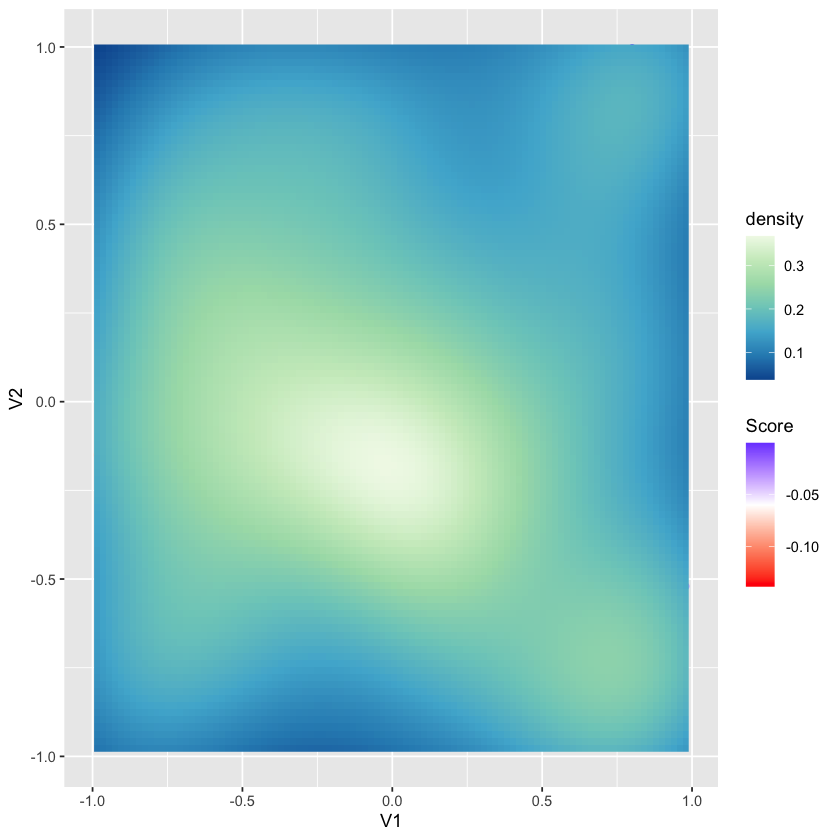

In [16]:
ggplot(as.data.frame(spatial_density), aes(x = V1, y = V2, colour = Score))  +   geom_point(position = 'jitter') + scale_color_gradient2( midpoint = -0.06,low = 'red',  high = ("blue")) +
  stat_density_2d(aes(fill = ..density..), geom = "raster", contour = FALSE) + scale_fill_distiller(palette=4, direction=-1)
ggsave(filename = 'plots/raster.png')

## Latent Space Algebra 
Computing Vectors in latent space based on altering channel make up. We will take a point on training set, and replace step-4 in sequence with alternate thereby creating different combinations (different sequencing).

We will take the same points as done in tf_rnn (RNN only model)

Its computationally heavy procedure.

In [32]:
df_cust = df_paths[customer_id=='id99']
df_cust

customer_id,path_no,path,V1,V2,V3,V4,V5,target
<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
id99,1,channel_8->channel_1->channel_6->channel_1->channel_1->channel_1->channel_8,channel_8,channel_1,channel_6,channel_1,channel_1,0


***space_cust1000 = compute_newpoint(new_point = df_cust1000 , encoder=encoder_ts)**

In [33]:
space_cust = compute_newpoint(new_point = df_cust , encoder=encoder_ts)
space_cust

tf.Tensor([[-0.04697983 -0.19773924]], shape=(1, 2), dtype=float32)


V1,V2,Score,SD
-0.04697983,-0.1977392,-0.1282205,0.2822869


In [35]:
df_altered0 = df_paths[customer_id=='id99', V4 := 'channel_0'][customer_id=='id99'] 
df_altered7 = df_paths[customer_id=='id99', V4 := 'channel_7'][customer_id=='id99'] 
(df_altered7)
(df_altered0)

customer_id,path_no,path,V1,V2,V3,V4,V5,target
<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
id99,1,channel_8->channel_1->channel_6->channel_1->channel_1->channel_1->channel_8,channel_8,channel_1,channel_6,channel_7,channel_1,0


customer_id,path_no,path,V1,V2,V3,V4,V5,target
<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
id99,1,channel_8->channel_1->channel_6->channel_1->channel_1->channel_1->channel_8,channel_8,channel_1,channel_6,channel_0,channel_1,0


## Observe Score
Check out how altering the a channel in a step changes position in latent space and the associated scores.

In [36]:
space_cust_0 = compute_newpoint(new_point = df_altered0 , encoder=encoder_ts)
space_cust_7 = compute_newpoint(new_point = df_altered7 , encoder=encoder_ts)
space_cust_0
space_cust_7 

tf.Tensor([[-0.11544285 -0.0902838 ]], shape=(1, 2), dtype=float32)
tf.Tensor([[0.08842012 0.02953122]], shape=(1, 2), dtype=float32)


V1,V2,Score,SD
-0.1154428,-0.0902838,-0.1255109,0.2840088


V1,V2,Score,SD
0.08842012,0.02953122,-0.1077992,0.2873845


## Next Best Action (NBA)
One can perform grid serach for future steps (1..n) steps forward or any other optimization technique to lay out future channel treatments.

In [38]:
# Next Best Action
nba = nextBestAction(sub_path=df_cust,encoder = encoder_ts)
nba

tf.Tensor([[-0.05254993 -0.18030465]], shape=(1, 2), dtype=float32)
tf.Tensor([[-0.01330902 -0.16689804]], shape=(1, 2), dtype=float32)
tf.Tensor([[-0.02780541 -0.2128832 ]], shape=(1, 2), dtype=float32)
tf.Tensor([[ 0.01730644 -0.20839766]], shape=(1, 2), dtype=float32)
tf.Tensor([[ 0.01812436 -0.18077475]], shape=(1, 2), dtype=float32)
tf.Tensor([[0.24079907 0.05768254]], shape=(1, 2), dtype=float32)
tf.Tensor([[-0.0709872 -0.1510353]], shape=(1, 2), dtype=float32)
tf.Tensor([[0.2135746  0.05371334]], shape=(1, 2), dtype=float32)
tf.Tensor([[-0.04237039 -0.12475923]], shape=(1, 2), dtype=float32)


step_1,step_2,step_3,step_4,step_5,V1,V2,Score,SD
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
channel_8,channel_1,channel_6,channel_1,channel_0,-0.05254993,-0.18030465,-0.12787419,0.2834300
channel_8,channel_1,channel_6,channel_1,channel_1,-0.01330902,-0.16689804,-0.12582589,0.2856024
channel_8,channel_1,channel_6,channel_1,channel_2,-0.02780541,-0.21288320,-0.12789134,0.2816000
channel_8,channel_1,channel_6,channel_1,channel_3,0.01730644,-0.20839766,-0.12566768,0.2826949
channel_8,channel_1,channel_6,channel_1,channel_4,0.01812436,-0.18077475,-0.12477933,0.2849766
channel_8,channel_1,channel_6,channel_1,channel_5,0.24079907,0.05768254,-0.09313414,0.2744607
channel_8,channel_1,channel_6,channel_1,channel_6,-0.07098720,-0.15103529,-0.12738004,0.2844764
channel_8,channel_1,channel_6,channel_1,channel_7,0.21357460,0.05371334,-0.09591485,0.2776235
channel_8,channel_1,channel_6,channel_1,channel_8,-0.04237039,-0.12475923,-0.12522213,0.2870968


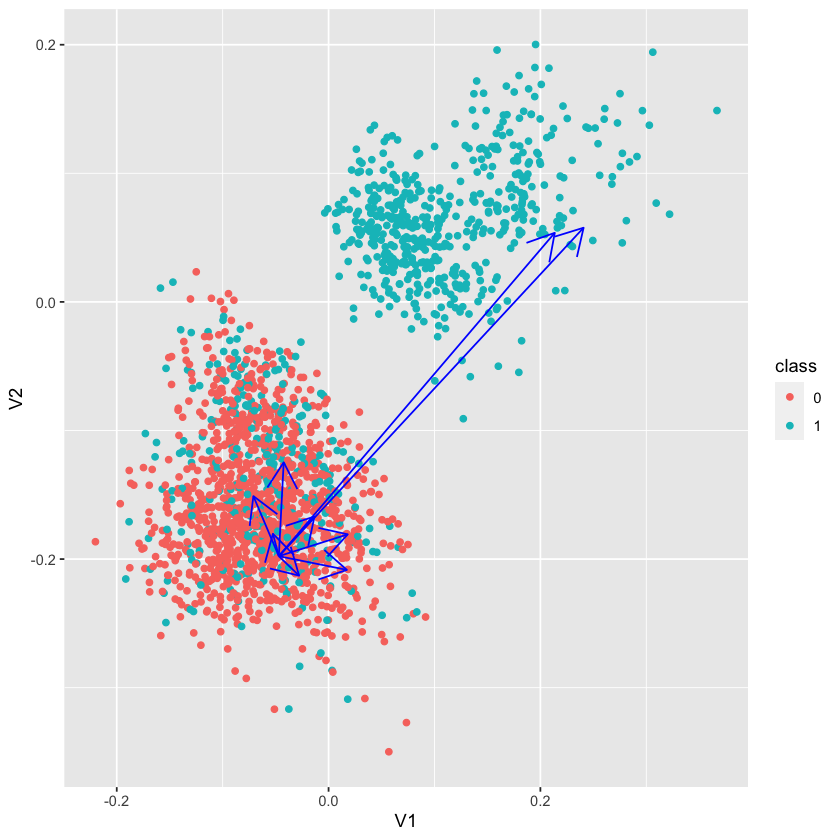

In [43]:
p_nba = p_lp + geom_segment(data= cbind(nba[,V1:V2],V3=space_cust[,'V1'],V4=space_cust[,'V2']),
                    aes(x=V3,y=V4,xend=V1,yend=V2),arrow = arrow(),
                    color = 'blue') 
p_nba

In [44]:
ggsave(p_nba,filename = 'plots/nba.png' )


Saving 7 x 7 in image

